This is the code to prepare data for mchine learning models.

# https://www.youtube.com/watch?v=7_Js8h709Dw
# https://pypi.org/project/ydata-profiling/


In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import useful_functions as uf
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV


In [2]:
# Importing the dataset
df_raw = pd.read_csv('../data/cleanned_df.csv')


In [3]:
# Let's drop some columns that are not useful for our analysis
columns_to_drop = ['ECO_fiscal_result_12months', 'ECO_inflation_12months','ECO_gross_debt_gdp_pre', 'ECO_gross_debt_gdp_pos',
       'ECO_gross_debt_R$_pre', 'ECO_gross_debt_R$_pos', 'ECO_net_debt_gdp_%',
       'ECO_net_debt_R$', 'ECO_net_debt_gdp_%_federal_govt',
       'ECO_net_debt_R$_federal_govt', 'ECO_net_debt_R$_dlspc']

# Dropping columns
df_raw.drop(columns_to_drop, axis=1, inplace=True)

# Rename a column
df_raw.rename(columns={"Euro area (19 countries)":"WD_Euro area (19 countries)"}, inplace=True)

# Setting date as index
df_raw.set_index('Date', inplace=True)

df_raw.to_csv('../data/data_orig_parameters.csv', index=True)

### Feature Selection

In [4]:
# Define test and validation set sizes
# target variable
target_variable = df_raw.columns[0]

# Create X and y
X_train = df_raw.drop(target_variable, axis=1)
y_train = df_raw[target_variable]

# Define the most XX important features
number_of_features = 40

In [5]:
target_variable

'ECO_fiscal_result_month'

### Random Forest feature selection evaluation

In [6]:
def plot_selected_features(dataframe, number_of_features, model_used):

    # Plot a bar chart 
    plt.figure(figsize=(10, 5))
    plt.barh(dataframe.iloc[:,0][:number_of_features], # select the most important features names
            dataframe.iloc[:,1][:number_of_features]) # select the importance values of these features
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance using {}'.format(model_used))
    plt.gca().invert_yaxis() # present the most important feature at the top
    plt.show()

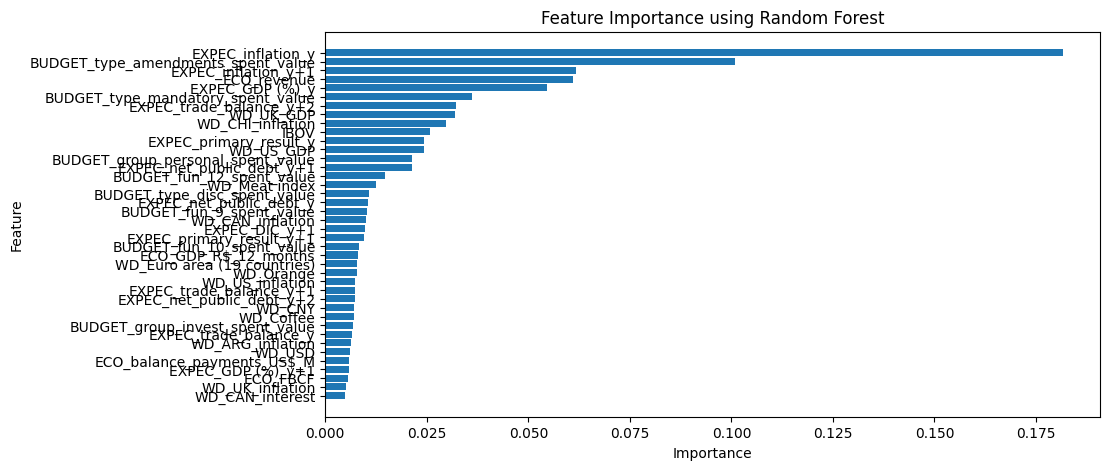

In [9]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Obtain feature importance
feature_importances = model.feature_importances_

# Create a DataFrame to visualize feature importance
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plot_selected_features(features_df, number_of_features, 'Random Forest')

# subset df_raw with the most important features
data_cleaned_RF = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Change the column order to have the target variable in the first position


# Export the most important features to a csv file
data_cleaned_RF.to_csv('../data/data_cleaned_RF.csv', index=True)


In [10]:
data_cleaned_RF.columns

Index(['ECO_fiscal_result_month', 'EXPEC_inflation_y',
       'BUDGET_type_amendments_spent_value', 'EXPEC_inflation_y+1',
       'ECO_revenue', 'EXPEC_GDP (%)_y', 'BUDGET_type_mandatory_spent_value',
       'EXPEC_trade_balance_y+2', 'WD_UK_GDP', 'WD_CHI_inflation', 'IBOV',
       'EXPEC_primary_result_y', 'WD_US_GDP',
       'BUDGET_group_personal_spent_value', 'EXPEC_net_public_debt_y+1',
       'BUDGET_fun_12_spent_value', 'WD_Meat index',
       'BUDGET_type_disc_spent_value', 'EXPEC_net_public_debt_y',
       'BUDGET_fun_9_spent_value', 'WD_CAN_inflation', 'EXPEC_DIC_y+1',
       'EXPEC_primary_result_y+1', 'BUDGET_fun_10_spent_value',
       'ECO_GDP_R$_12_months', 'WD_Euro area (19 countries)', 'WD_Orange',
       'WD_US_inflation', 'EXPEC_trade_balance_y+1',
       'EXPEC_net_public_debt_y+2', 'WD_CNY', 'WD_Coffee',
       'BUDGET_group_invest_spent_value', 'EXPEC_trade_balance_y',
       'WD_ARG_inflation', 'WD_USD', 'ECO_balance_payments_US$_M',
       'EXPEC_GDP (%)_y+1', '

### Feature Importance using Lasso model

The best alpha parameter is:  202


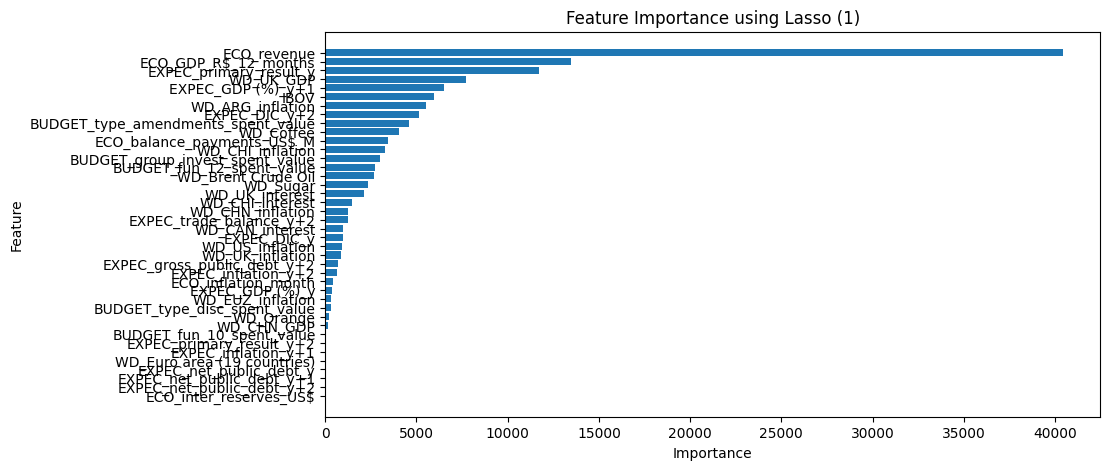

In [11]:
# Define the best alpha parameter for the Lasso model

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define some alphas to test which one is the best
alphas = [10, 100, 150, 165, 175, 185, 190, 195, 200, 202, 210, 215, 230, 250, 300, 500]

# Initialize the LassoCV model
lasso_cv = LassoCV(alphas=alphas, max_iter = 10000000, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_
print('The best alpha parameter is: ', best_alpha)

# Get the coefficients of the model
features_df = pd.DataFrame(lasso_cv.coef_, X_train.columns, columns=['coefficients'])

# Order the coefficients by absolute value
features_df = features_df.abs().sort_values(by='coefficients', ascending=False)

# Make the index a column and rename it to "features"
features_df.reset_index(inplace=True)
features_df.rename(columns={'index':'Feature'}, inplace=True)

plot_selected_features(features_df, number_of_features, 'Lasso (1)')

# subset df_raw with the most important features
data_cleaned_LASSO = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_LASSO.to_csv('../data/data_cleaned_LASSO.csv', index=True)

### RFE

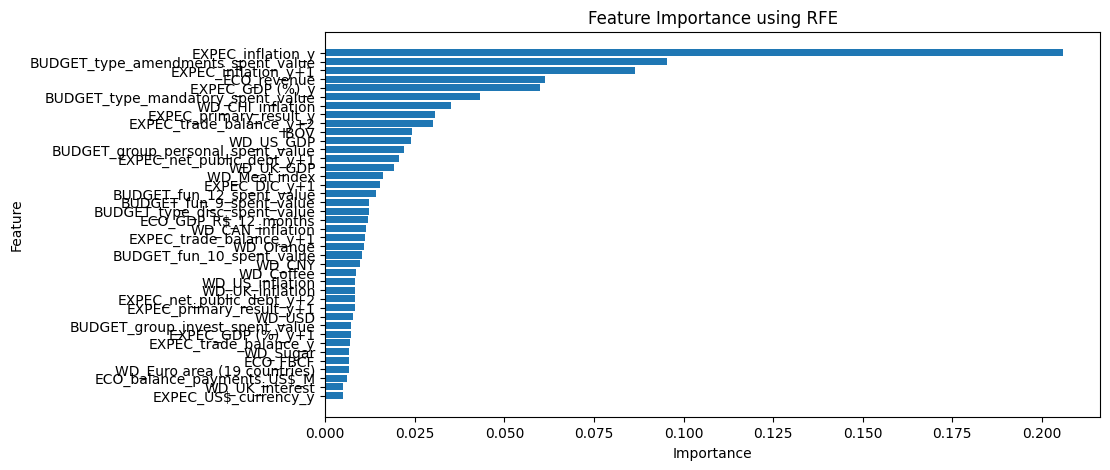

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
modelo = RandomForestRegressor()

# Initialize the RFE model
rfe = RFE(estimator=modelo, n_features_to_select=number_of_features)

# Fit the RFE model
rfe.fit(X_train, y_train)

# Check the most important features
seleced_variables = X_train.columns[rfe.support_]
coefficients = rfe.estimator_.feature_importances_

# Combine both in a dataframe called "features_df"
features_df = pd.DataFrame({'Feature': seleced_variables, 'Importance': coefficients})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot a bar chart 
plot_selected_features(features_df, number_of_features, 'RFE')

# subset df_raw with the most important features
data_cleaned_RFE = df_raw[[target_variable] + features_df.iloc[:,0][:number_of_features].to_list()]

# Export the most important features to a csv file
data_cleaned_RFE.to_csv('../data/data_cleaned_RFE.csv', index=True)


### Create Synthetic data?

In [23]:
# # Let's create some synthetic data to help us with the EDA
# lags = [6, 12]

# # Create synthetic data
# synthetic_data = uf.create_synthetic_data(df_raw, lags)

# # Merge the original data with the synthetic data
# BR_param_EDA = pd.concat([df_raw, synthetic_data], axis=1)

# # Exporting the dataset
# BR_param_EDA.to_csv('../data/BR_param_EDA.csv', index=True)

Let's make our series stationary

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Undo%20Stationary%20Transformations.ipynb

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Time%20Series%20Data%20Preprocessing.ipynb

https://www.youtube.com/watch?v=tjfqfDAqtR4